# HW5

## 1. Signal reconstruction with $\mathscr{L}_1$-penalization (6 points)

**1.** Propose three test signals $x_i, i = 1, \ldots , 1000$: e.g., piece-wise linear continuous, piece-wise linear discontinuous, quadratic spline.

**2.** Corrupt your signal adding gaussian and/or random bounded noise:

$$y = x + \xi$$

**3.** For each of three test signals run a recovery procedure with penalties $\left|\left| D_1 \hat x \right|\right|_2, \left|\left| D_1 \hat x \right|\right|_1, \left|\left| D_2 \hat x \right|\right|_1$:

$$\\
    D_1 = \begin{pmatrix}
    1 & -1 & 0 & \ldots & 0 & 0 \\
    0 & 1 & -1 & \ldots & 0 & 0 \\
    \ldots & \ldots & \ldots & \ldots & \ldots & \ldots \\
    0 & 0 & 0 & \ldots & 1 & -1
\end{pmatrix}
$$


$$\\
    D_2 = \begin{pmatrix}
    1 & -2 & 1 & 0 & \ldots & 0 & 0 \\
    0 & 1 & -2 & 1 & \ldots & 0 & 0 \\
    \ldots & \ldots & \ldots & \ldots & \ldots & \ldots & \ldots \\
    0 & 0 & 0 & \ldots & 1 & -2 & 1
\end{pmatrix}
$$

**4.** Explore dependancy on $\gamma$. Plot penalty (e.g., $\left|\left| D_1 \hat x \right|\right|_2$) vs $\left|\left| y - \hat x \right|\right|_2$ for different $\gamma$, you’ll get the curve implicitly parameterized by $\gamma$. Which $\gamma$ looks like the optimal choice for each case?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rc
%matplotlib inline

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

from cvxpy import *

### 1.1. Creating test signals

In [3]:
# piece-wise linear continuous

def saw_one(x, a):
        
    if x < a:
            
        return x
        
    elif (x >= a) and (x < 2. * a):
            
        return -2. * x + 3. * a
        
    else:
            
        return 4. * x - 9. * a
        
def saw(x, a):
    
    x = x - np.floor(x / (63. * a/16.)) * (63. * a/16.)
    
    if x < 9. * a / 4.:
        
        return saw_one(x, a)
        
    elif (x >= 9. * a / 4.) and (x < 27. * a / 8.):
        
        return saw_one(x - 9. * a / 4., a / 2.)
    
    else:
        
        return saw_one(x - 27. * a / 8., a / 4.)

In [4]:
# piece-wise linear discontinuous

def saw_one_disc(x, a):
        
    if x < a:
            
        return x
        
    else:
            
        return -3. * x + 5. * a
        
def saw_disc(x, a):
    
    x = x - np.floor(x / (7. * a / 2.)) * (7. * a / 2.)
    
    if x < 2. * a:
        
        return saw_one_disc(x, a)
        
    elif (x >= 2. * a) and (x < 3. * a):
        
        return saw_one_disc(x - 2. * a, a / 2.)
    
    else:
        
        return saw_one_disc(x - 3. * a, a / 4.)

In [5]:
# quadratic spline

def saw_one_quad(x, a, gamma):
        
    if x < 3. * a / 2.:
            
        return gamma * x * (2. * x / (3. * a) - 1.)
        
    else:
            
        return - 4. * gamma / (3. * a) * (x - 3. * a / 2.) * (x - 9. * a / 4.)
        
def saw_quad(x, a, gamma):
    
    x = x - np.floor(x / (63. * a / 16.)) * (63. * a / 16.)
    
    if x < 9. * a / 4.:
        
        return saw_one_quad(x, a, gamma)
        
    elif (x >= 9. * a / 4.) and (x < 27. * a / 8.):
        
        return saw_one_quad(x - 9. * a / 4., a / 2., gamma)
    
    else:
        
        return saw_one_quad(x - 27. * a / 8., a / 4., gamma)

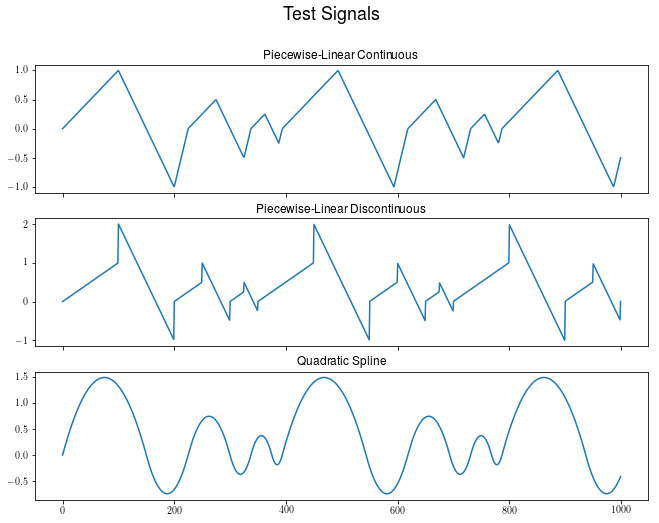

In [6]:
# plotting test signals

N = 10
n = 1000

points = np.linspace(0, N, n)

a = 1.
gamma = -4.

piecewise_linear = np.vectorize(saw)
piecewise_linear_disc = np.vectorize(saw_disc)
quad_spline = np.vectorize(saw_quad)

pl = piecewise_linear(points, a)
pl_d = piecewise_linear_disc(points, a)
qs = quad_spline(points, a, gamma)

f, ax = plt.subplots(3, 1, figsize=(11, 8), sharex=True)
f.suptitle('Test Signals', fontsize=18)
ax[0].plot(pl)
ax[0].set_title('Piecewise-Linear Continuous')
ax[1].plot(pl_d)
ax[1].set_title('Piecewise-Linear Discontinuous')
ax[2].plot(qs)
ax[2].set_title('Quadratic Spline')
plt.show()

### 1.2. Corrupting test signals with Gaussian noise $\mathscr{N}(0, \sigma)$

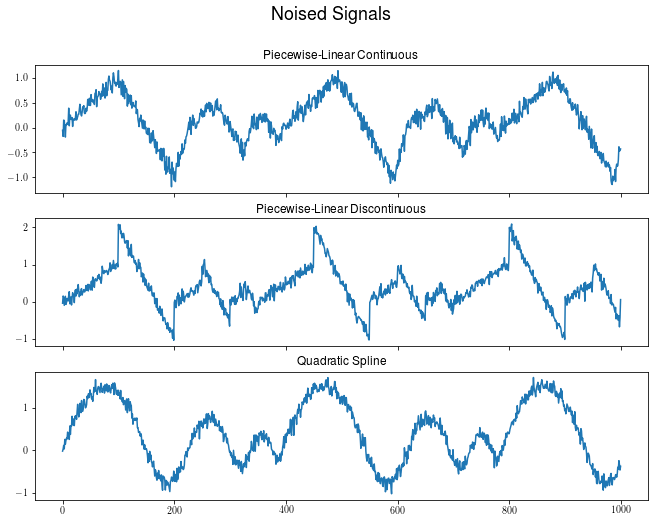

In [7]:
sigma = 0.1

pl_noised = pl + np.random.normal(0, sigma, n)
pl_d_noised = pl_d + np.random.normal(0, sigma, n)
qs_noised = qs + np.random.normal(0, sigma, n)

f, ax = plt.subplots(3, 1, figsize=(11, 8), sharex=True)
f.suptitle('Noised Signals', fontsize=18)
ax[0].plot(pl_noised)
ax[0].set_title('Piecewise-Linear Continuous')
ax[1].plot(pl_d_noised)
ax[1].set_title('Piecewise-Linear Discontinuous')
ax[2].plot(qs_noised)
ax[2].set_title('Quadratic Spline')
plt.show()

### 1.3. - 1.4. Recovering signals

In [8]:
# matrices for regularization

def D1_matrix(n):

    D1 = np.zeros((n-1, n))
    np.fill_diagonal(D1, -1.)

    D1 = np.roll(D1, 1)

    np.fill_diagonal(D1, 1.)
    
    return D1

def D2_matrix(n):

    D2 = np.zeros((n-2, n))
    np.fill_diagonal(D2, 1.)

    D2 = np.roll(D2, 1)

    np.fill_diagonal(D2, -2.)

    D2 = np.roll(D2, 1)

    np.fill_diagonal(D2, 1.)

    return D2

D1 = D1_matrix(n)
D2 = D2_matrix(n)

In [9]:
# main functions

def find_min_lambda(signal, signal_noised, lambdas, D, m):
    
    n = signal.shape[0]
    
    x = Variable(n)
    
    fidelity = 0.5*sum_squares(signal_noised - x)
    
    reg = norm(D*x, m)
    
    norms = []

    for l in lambdas:

        prob = Problem(Minimize(fidelity + l * reg))
        prob.solve()

        norms = np.append(norms, np.linalg.norm(signal - x.value))

    lambda_min = lambdas[np.argmin(norms)]

    plt.plot(lambdas, norms)
    plt.title('Dependency of $\\left|\\left| x - \\hat x \\right|\\right|_2$ on $\lambda$\n$$\lambda_m_i_n = {0:2.2f}$$'
              .format(np.round(lambda_min, 2)), fontsize=18)
    plt.ylabel('$\\left|\\left| x - \\hat x \\right|\\right|_2$', fontsize=16)
    plt.xlabel('$\lambda$', fontsize=16)
    plt.show()
    
    return lambda_min

def signal_reconstruction(signal, signal_noised, l_min, D, m, s_type):
    
    n = signal.shape[0]
    
    x = Variable(n)

    coefs = [0.25, 1, 4, 10]
    ls_for_plot = l_min * np.array(coefs)
    coefs[1] = ''

    fidelity = 0.5*sum_squares(signal_noised - x)

    reg = norm(D*x, m)

    x_arr = []

    for l in ls_for_plot:

        prob = Problem(Minimize(fidelity + l * reg))
        prob.solve()

        x_arr.append(x.value)

    f, ax = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
    f.suptitle('{0} with regularizer $||D_{1} \\hat x||_{2}$'.format(s_type, int(np.abs(D[0,1])), m), fontsize=18)

    for (i, xs) in enumerate(x_arr):

        ax[i].plot(signal, label = 'Original signal')
        ax[i].plot(xs, label = 'Reconstructed signal')
        ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        ax[i].set_title('$\lambda = {0} \\lambda_m_i_n$'.format(coefs[i]))

    plt.show()

### Piecewise-Linear Continuous signal

### $\left|\left| D_1 x \right|\right|_2$

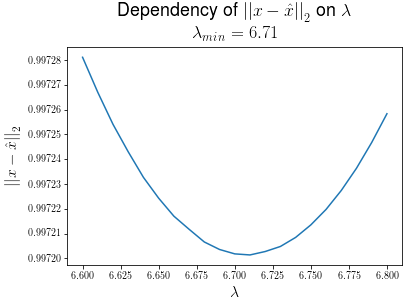

In [16]:
signal = pl
signal_noised = pl_noised
lambdas = np.linspace(6.6, 6.8, 21)
D = D1
m = 2
l_min = find_min_lambda(signal, signal_noised, lambdas, D, m)

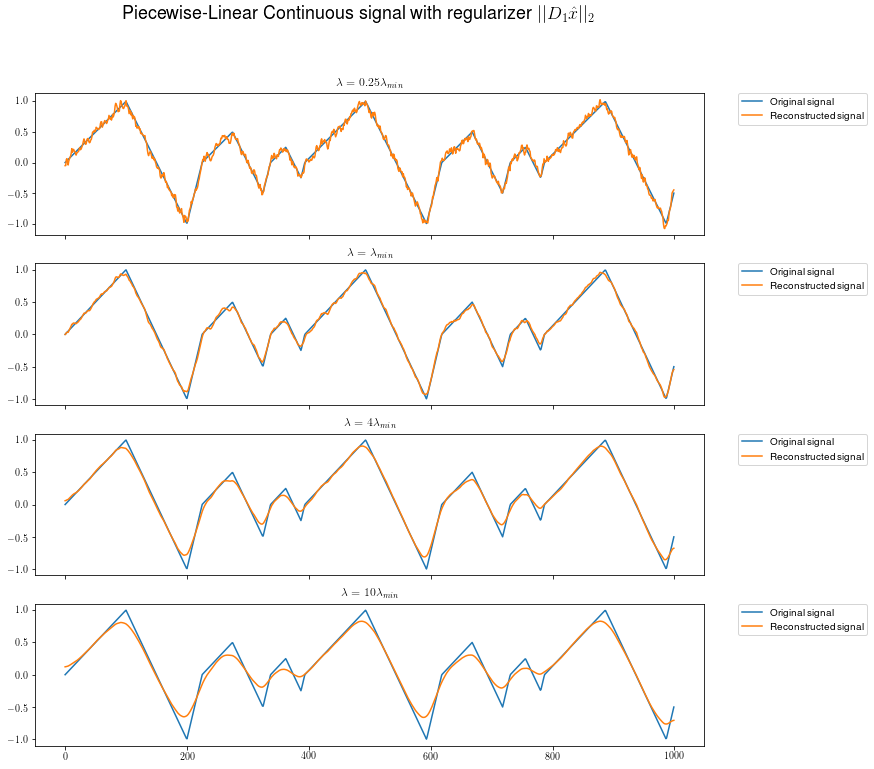

In [17]:
s_type = 'Piecewise-Linear Continuous signal'
signal_reconstruction(signal, signal_noised, l_min, D, m, s_type)

### $\left|\left| D_1 x \right|\right|_1$

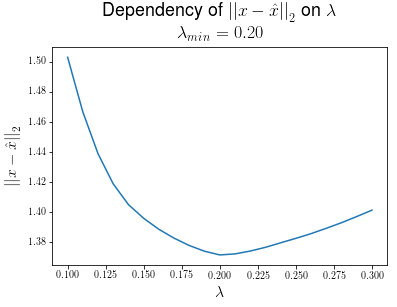

In [19]:
lambdas = np.linspace(0.1, 0.3, 21)
m = 1
l_min = find_min_lambda(signal, signal_noised, lambdas, D, m)

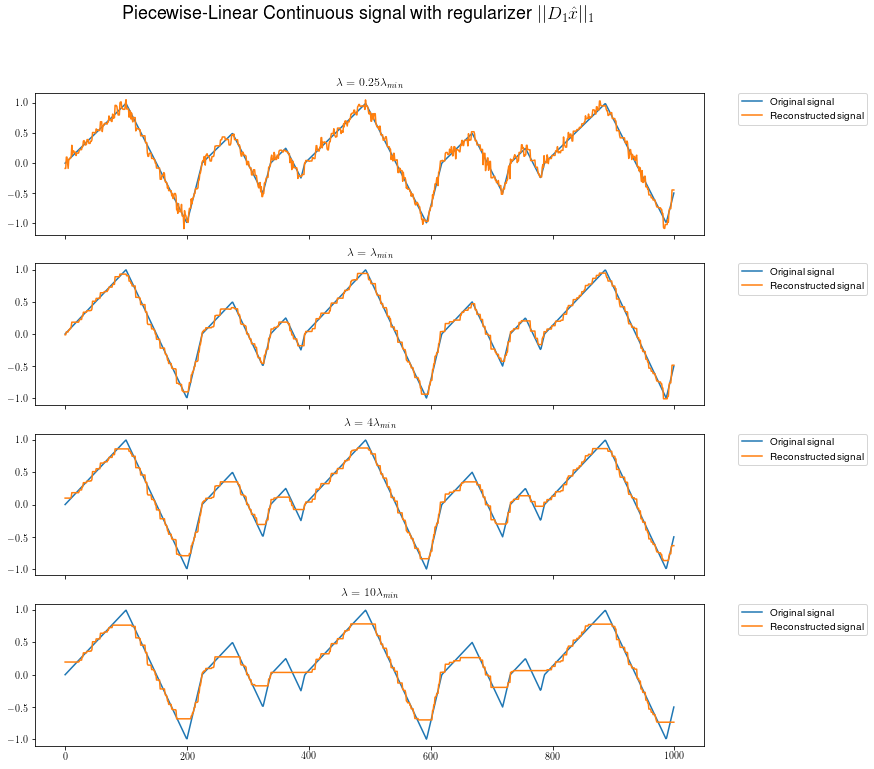

In [20]:
signal_reconstruction(signal, signal_noised, l_min, D, m, s_type)

### $\left|\left| D_2 x \right|\right|_1$

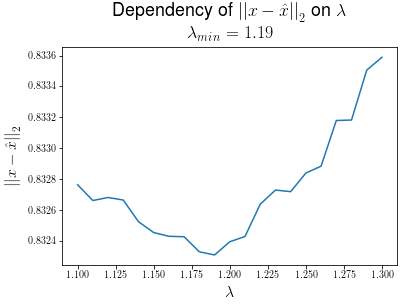

In [28]:
lambdas = np.linspace(1.1, 1.3, 21)
D = D2
l_min = find_min_lambda(signal, signal_noised, lambdas, D, m)

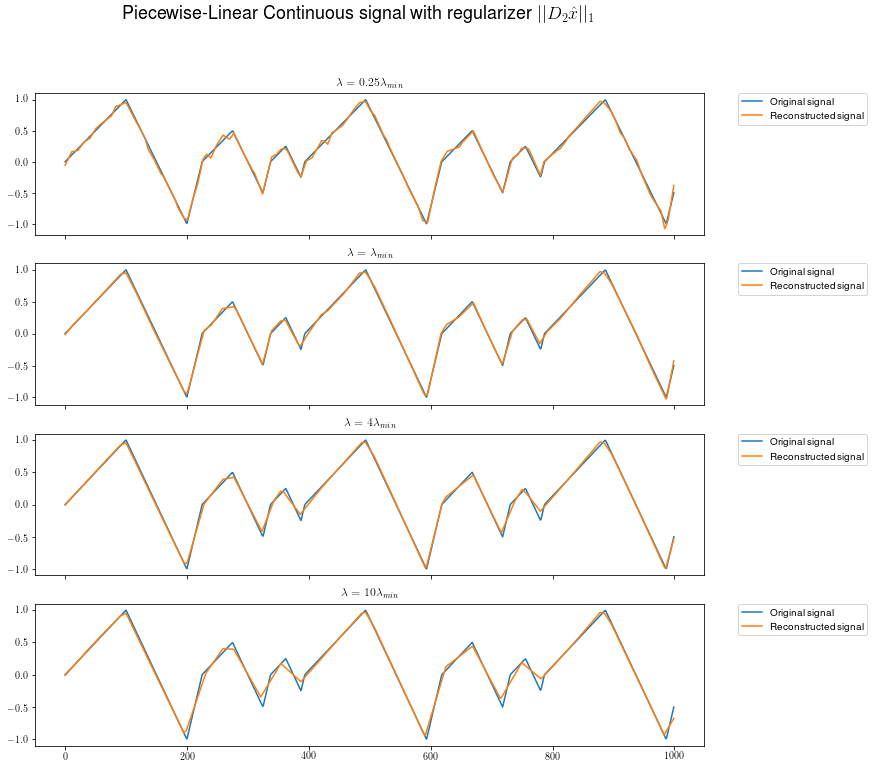

In [29]:
signal_reconstruction(signal, signal_noised, l_min, D, m, s_type)

### Piecewise-Linear Discontinuous signal

### $\left|\left| D_1 x \right|\right|_2$

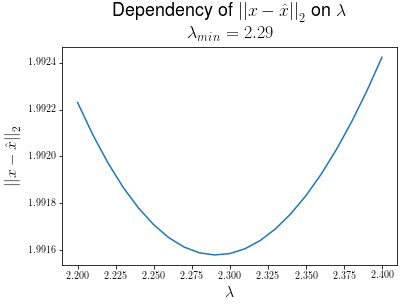

In [34]:
signal = pl_d
signal_noised = pl_d_noised
lambdas = np.linspace(2.2, 2.4, 21)
D = D1
m = 2
l_min = find_min_lambda(signal, signal_noised, lambdas, D, m)

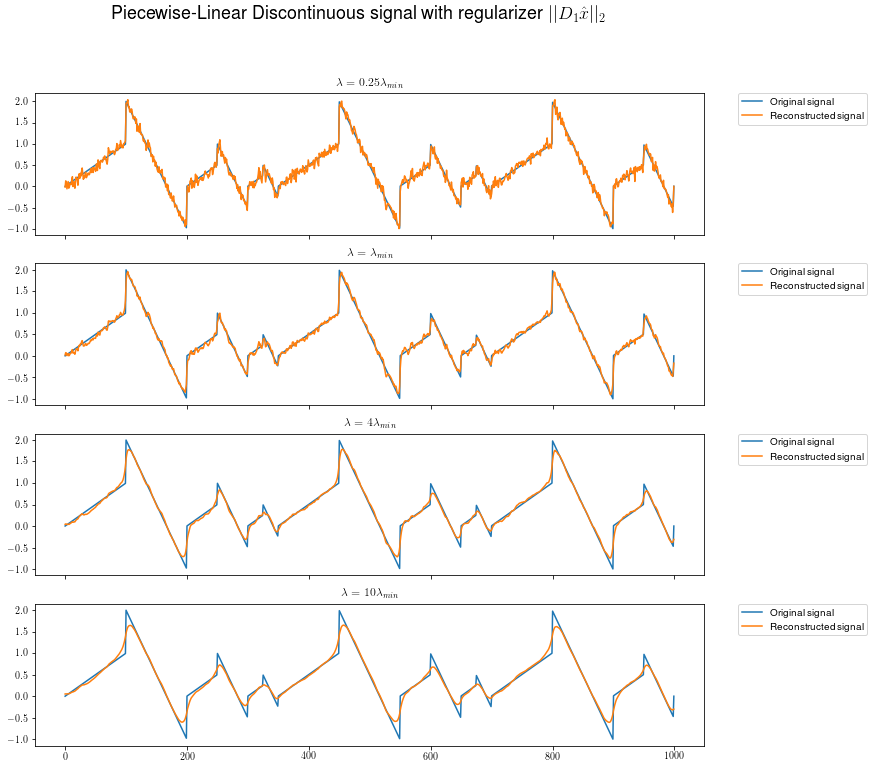

In [35]:
s_type = 'Piecewise-Linear Discontinuous signal'
signal_reconstruction(signal, signal_noised, l_min, D, m, s_type)

### $\left|\left| D_1 x \right|\right|_1$

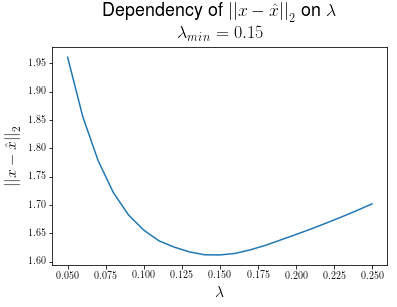

In [37]:
lambdas = np.linspace(0.05, 0.25, 21)
m = 1
l_min = find_min_lambda(signal, signal_noised, lambdas, D, m)

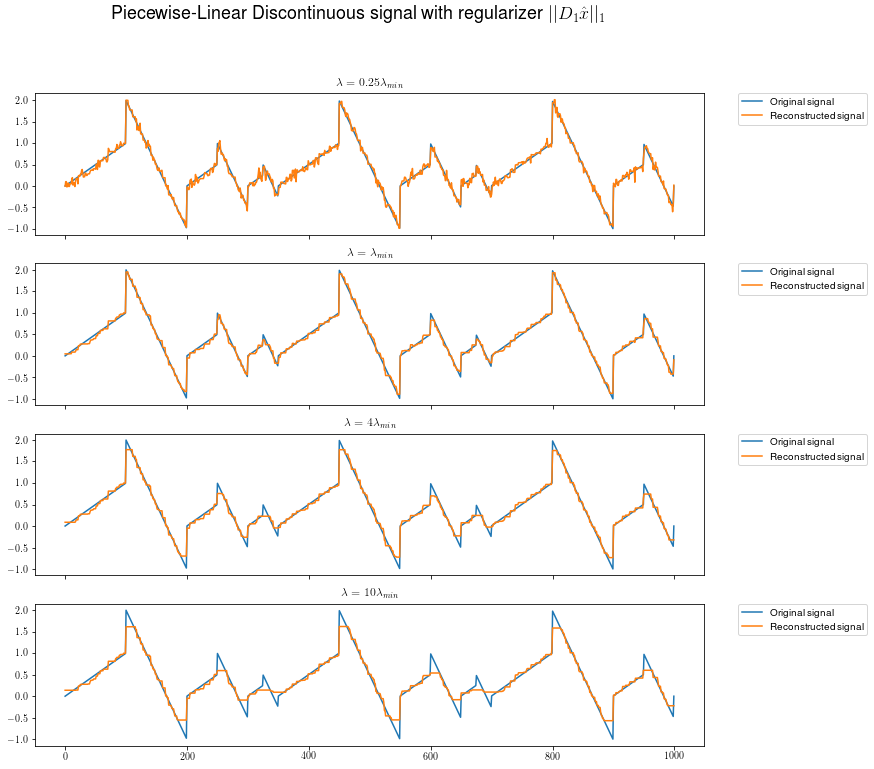

In [38]:
signal_reconstruction(signal, signal_noised, l_min, D, m, s_type)

### $\left|\left| D_2 x \right|\right|_1$

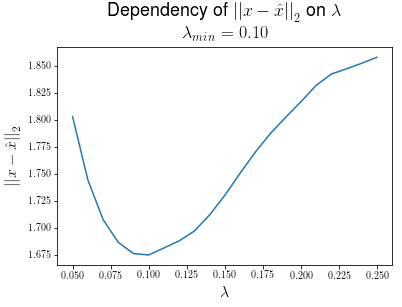

In [39]:
lambdas = np.linspace(0.05, 0.25, 21)
D = D2
l_min = find_min_lambda(signal, signal_noised, lambdas, D, m)

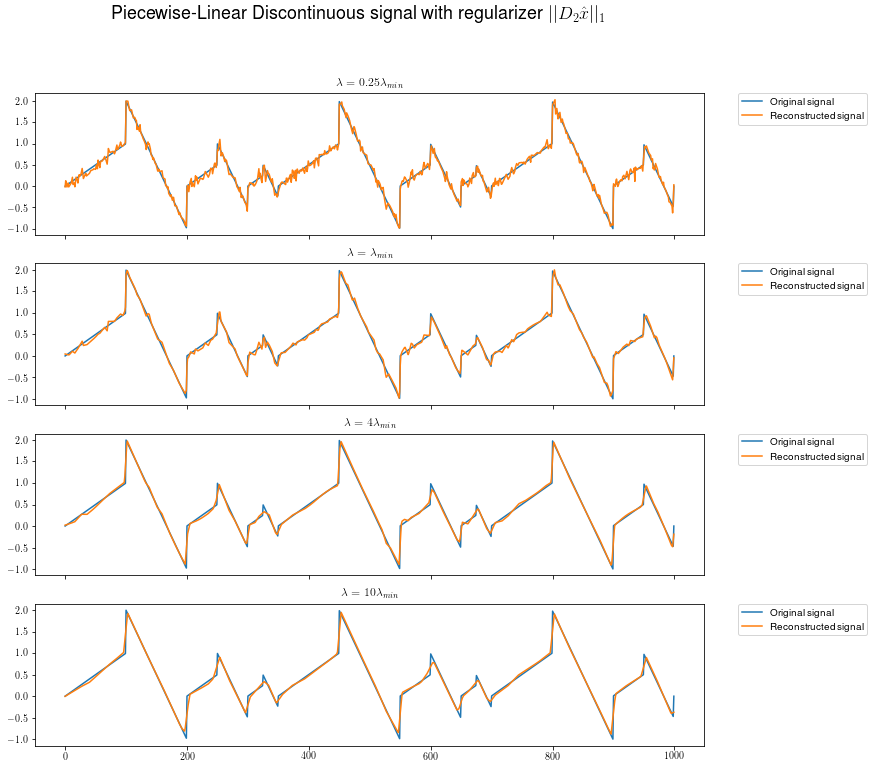

In [40]:
signal_reconstruction(signal, signal_noised, l_min, D, m, s_type)

### Quadratic Spline

### $\left|\left| D_1 x \right|\right|_2$

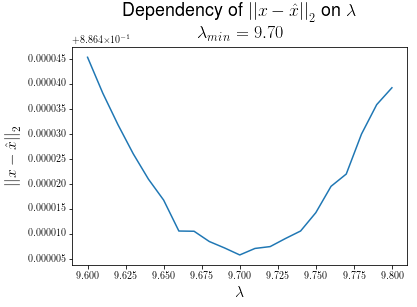

In [49]:
signal = qs
signal_noised = qs_noised
lambdas = np.linspace(9.6, 9.8, 21)
D = D1
m = 2
l_min = find_min_lambda(signal, signal_noised, lambdas, D, m)

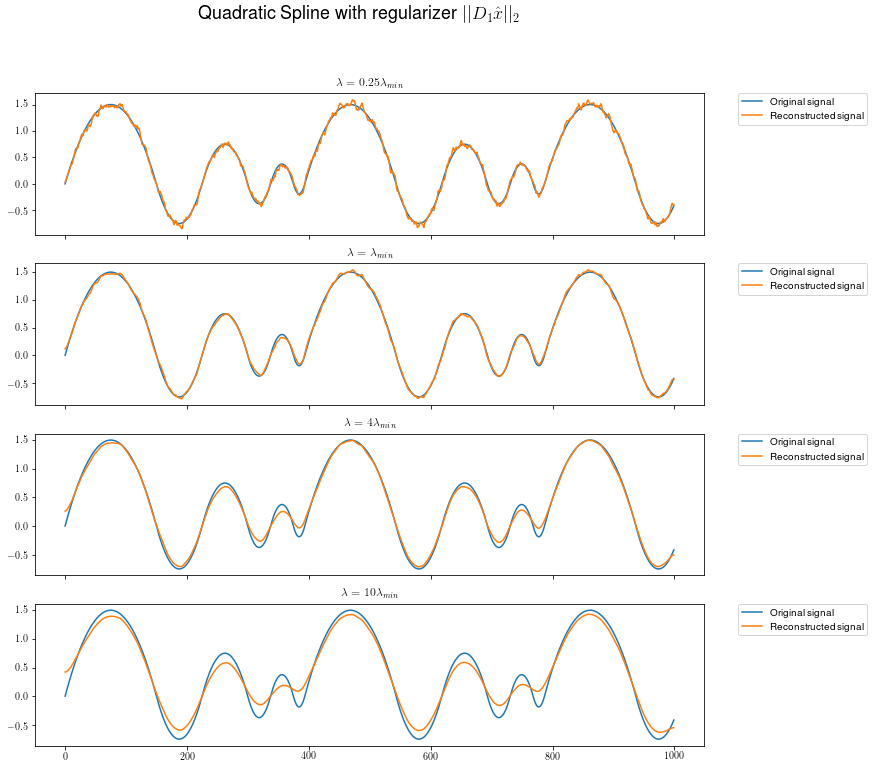

In [50]:
s_type = 'Quadratic Spline'
signal_reconstruction(signal, signal_noised, l_min, D, m, s_type)

### $\left|\left| D_1 x \right|\right|_1$

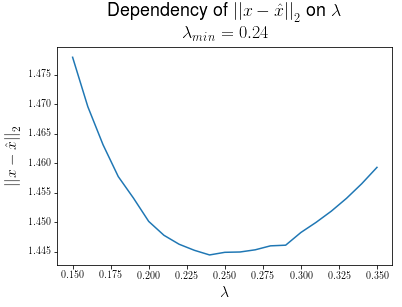

In [51]:
lambdas = np.linspace(0.15, 0.35, 21)
m = 1
l_min = find_min_lambda(signal, signal_noised, lambdas, D, m)

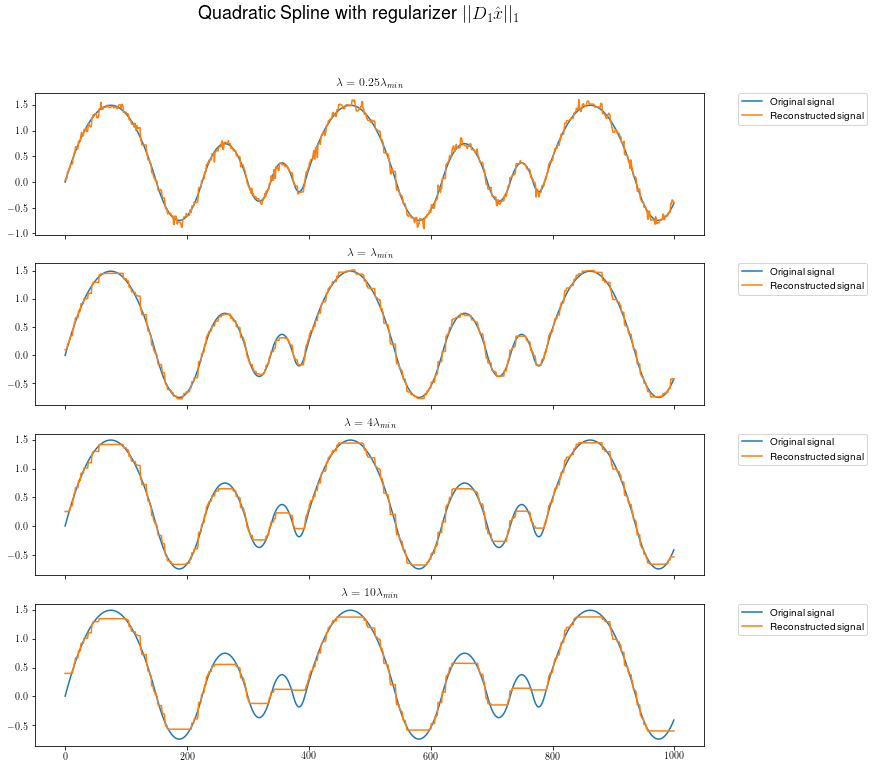

In [52]:
signal_reconstruction(signal, signal_noised, l_min, D, m, s_type)

### $\left|\left| D_2 x \right|\right|_1$

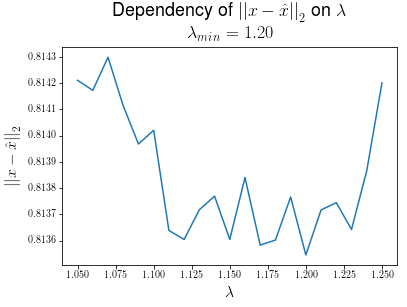

In [55]:
lambdas = np.linspace(1.05, 1.25, 21)
D = D2
l_min = find_min_lambda(signal, signal_noised, lambdas, D, m)

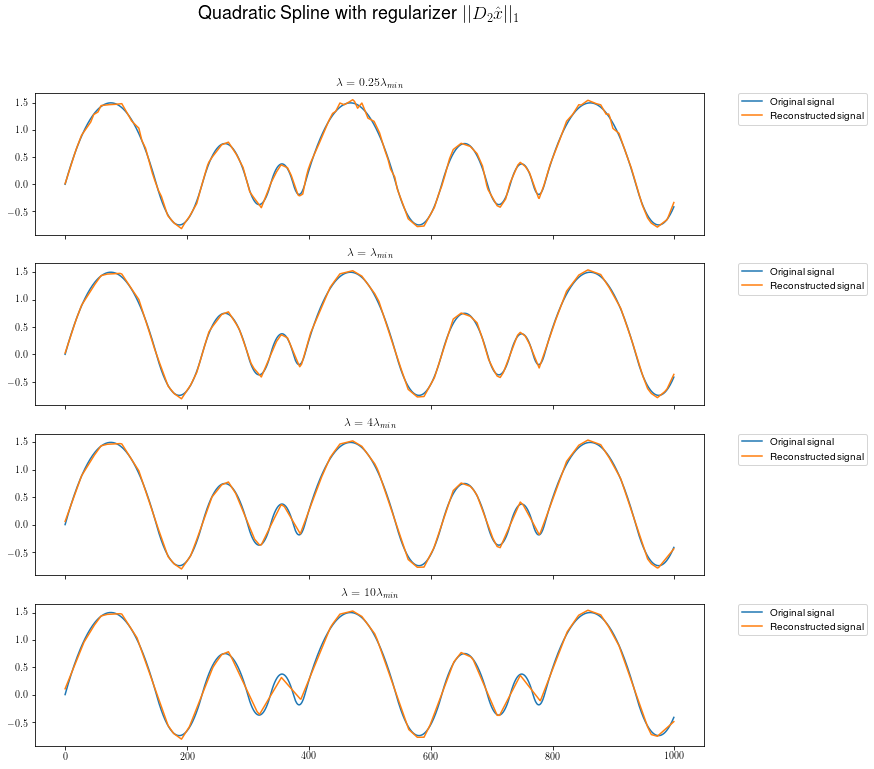

In [56]:
signal_reconstruction(signal, signal_noised, l_min, D, m, s_type)

## 2.  SDP and Schur complement (2 points)

For symmetric matrix $X = \begin{bmatrix}
    A & B \\
    B^T & C
\end{bmatrix}$ the following holds:

$$X \succ 0 \Longleftrightarrow A \succ 0,~~~C - B^T A^{-1} B \succ 0$$
$$X \succ 0 \Longleftrightarrow C \succ 0,~~~A - B C^{-1} B^T \succ 0$$

The expressions $C - B^T A^{-1} B$ and $A - B C^{-1} B^T$ are called Schur complement.

Use this structure to describe the fact:

$$a \in \mathcal{E},$$

i.e., point $a$ is inside the ellipsoid $\mathcal{E} = \left\{ x: (x - c)^T P^{-1} (x - c) \leq 1 \right\}$, as a Linear Matrix Inequality (LMI) with respect to $a$.

**Solution:**

Let's make the following substitutions: $B \rightarrow (a - c)$, $A \rightarrow P$, $C \rightarrow 1$. The ellipsoid definition then will coincide with the first identity:

$$C - B^T A^{-1} B \succ 0 \qquad \Longleftrightarrow \qquad 1 - (a - c)^T P^{-1} (a - c) > 0$$

It means that if $P \succ 0$, the following LMI holds:

$$\boxed{\begin{bmatrix}
    P & (a - c) \\
    (a - c)^T & 1
\end{bmatrix} \succ 0}$$

## 3. Minimal volume ellipsoid (4 points)

Given $N$ points on the plane $x^i = \left( x^i_1, x^i_2 \right)$. Find minimal volume ellipsoid containing these points. This is the concave problem:

$$\max \log{\left( \det{A} \right)}$$
$$\left|\left| A x^i + b \right|\right|^2_2 \leq 1,~i = 1, \ldots, N$$

The volume of the ellipsoid is proportional to $\det{A}$.

Plot randomly 10 points, calculate the parameters $A, b$ of minimal volume ellipsoid and plot this ellipsoid.

In [57]:
n = 2
m = 10

x = np.random.uniform(low=-100., high=100., size=(n,m))

A = Variable((n, n), symmetric=True)
b = Variable(n)
obj = Maximize(log_det(A))
constrs = [sum_squares(A*x[:, i]+b) <= 1 for i in range(m)]
prob = Problem(obj, constrs)
prob.solve(solver=CVXOPT, verbose=True, eps=1e-6)
print("\nOptimal value = {}".format(prob.value))
print("\nOptimal A = [{0},{1}], b = {2}".format(A.value[0], A.value[1], b.value))

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0693e+01  3e+01  1e+00  1e+00
 1:  9.7099e-02 -6.5535e+00  1e+01  5e-01  5e-01
 2:  6.1137e-01 -3.0701e+00  7e+00  3e-01  4e-01
 3:  2.7232e+00  6.4238e+00  3e+00  9e-01  3e+01
 4:  5.1582e+00  6.2219e+00  2e+00  4e-01  2e+01
 5:  5.6569e+00  6.5985e+00  2e+00  3e-01  1e+01
 6:  6.2387e+00  7.0788e+00  1e+00  2e-01  1e+01
 7:  7.0207e+00  7.6746e+00  7e-01  1e-01  6e+00
 8:  7.2856e+00  7.8042e+00  6e-01  1e-01  5e+00
 9:  7.7301e+00  8.0064e+00  3e-01  5e-02  2e+00
10:  8.0842e+00  8.1328e+00  2e-01  2e-02  1e+00
11:  8.1954e+00  8.2082e+00  8e-02  7e-03  4e-01
12:  8.2292e+00  8.2282e+00  5e-02  4e-03  2e-01
13:  8.2543e+00  8.2501e+00  2e-02  1e-03  8e-02
14:  8.2594e+00  8.2541e+00  2e-02  9e-04  5e-02
15:  8.2642e+00  8.2609e+00  7e-03  3e-04  2e-02
16:  8.2654e+00  8.2638e+00  3e-03  7e-05  5e-03
17:  8.2655e+00  8.2647e+00  1e-03  3e-05  2e-03
18:  8.2655e+00  8.2650e+00  8e-04  2e-05  1e-03
19:  8.2655e+00  8.26

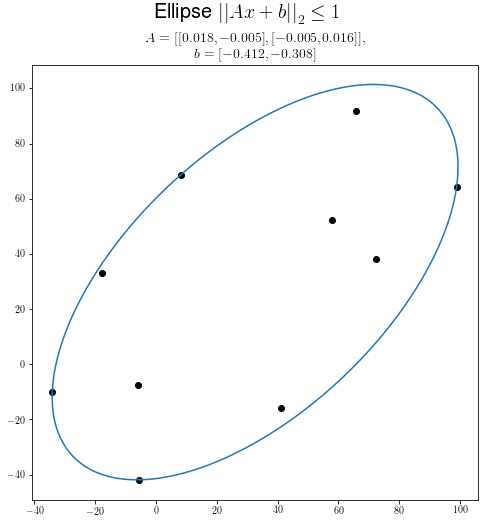

In [58]:
noangles = 200
angles = np.linspace(0., 2.*np.pi, noangles)

ellipse = np.linalg.solve(A.value, np.vstack((np.cos(angles) - b.value[0], np.sin(angles) - b.value[1])))

f, ax = plt.subplots(1, 1, figsize=(8, 8))

f.suptitle('Ellipse $\\left|\\left| Ax + b \\right|\\right|_2 \leq 1$', fontsize=20)

ax.scatter(x[0], x[1], color='black')
ax.plot(ellipse[0], ellipse[1])
ax.set_title('$$A = [[{0}, {1}], [{2}, {3}]],$$\n$$b = [{4}, {5}]$$'
             .format(np.round(A.value[0,0],3), np.round(A.value[0,1],3),
                     np.round(A.value[1,0],3), np.round(A.value[1,1],3),
                     np.round(b.value[0],3), np.round(b.value[1],3)), fontsize=14)
plt.show()